In [1]:
from flim.experiments import utils

import numpy as np

import torch

from torch import nn

from torch import optim

from torchvision import transforms

from torch_snippets import *

from sklearn.metrics import jaccard_score

from PIL import Image

import functools

from collections import OrderedDict


2021-09-19 20:56:35.385 | WARNING  | torch_snippets.loader:<module>:43 - Skipping cv2 import
2021-09-19 20:56:35.476 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [2]:
def get_device():
    gpu = torch.cuda.is_available()

    if not gpu:
        device = torch.device('cpu')
    else:
        device = torch.device(0)

    return device

In [3]:
# U-Net


def maybe_resize2d(x, shape):
        if x.shape[-2:] != shape[-2:]:
            x = F.interpolate(x, size=shape[-2:],
                            mode="bilinear", align_corners=True)
        return x
    
def maybe_resize3d(x, shape):
        if x.shape[-3:] != shape[-3:]:
            x = F.interpolate(x, size=shape[-3:],
                            mode="trilinear", align_corners=True)
        return x


def rgetattr(obj, attr, *args):
    
    def _getattr (obj, attr):
        return getattr(obj, attr, *args)

    return functools.reduce(_getattr, [obj] + attr.split('.'))

class IntermediateLayerGetter:
    def __init__(self, model, return_layers):
        self._model = model
        self._return_layers = return_layers

    def __call__(self, x):
        outputs = OrderedDict()
        handles = []

        for name, out_name in self._return_layers.items():
            layer = rgetattr(self._model, name)

            def hook(module, input, output, out_name=out_name):
                outputs[out_name] = output

            handle = layer.register_forward_hook(hook)

            handles.append(handle)
        
        self._model(x)

        for handle in handles:
            handle.remove()

        return outputs

def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )
    
def _layers_before_downscale(model):
    last_layer_name = None
    last_out_channel = None
    layer_names = []
    last_out_channels = []
    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Sequential)):
            continue
        if isinstance(layer, nn.Conv2d):
            last_out_channel = layer.out_channels
        if isinstance(layer, (nn.AvgPool2d, nn.MaxPool2d)):
            layer_names.append(last_layer_name)
            last_out_channels.append(last_out_channel)
        last_layer_name = name

    layer_names.append(last_layer_name)
    last_out_channels.append(last_out_channel)

    return layer_names, last_out_channels

class UNet(nn.Module):
    def __init__(self, encoder, out_channels=2):
        super().__init__()

        self.encoder = encoder

        encoder_block_names, block_out_channels = _layers_before_downscale(encoder)

        layer_names = {layer_name: layer_name for layer_name in encoder_block_names[:-1]}
        layer_names[encoder_block_names[-1]] = "bottleneck"

        self._encoder_blocks = IntermediateLayerGetter(self.encoder, layer_names)

        self.decoder = nn.Module()

        bottleneck_out_channels = block_out_channels[-1] * 2
        self.decoder.add_module("conv_bottleneck", conv(block_out_channels[-1], bottleneck_out_channels))

        last_conv_out_channels = bottleneck_out_channels
        for i, _out_channels in enumerate(reversed(block_out_channels[:-1])):

            self.decoder.add_module(f"up_conv{i}", up_conv(last_conv_out_channels, last_conv_out_channels//2))
            self.decoder.add_module(f"conv{i}", conv(last_conv_out_channels//2 + _out_channels, _out_channels))

            last_conv_out_channels = _out_channels
        
        self.decoder.add_module("output_layer", nn.Conv2d(last_conv_out_channels, out_channels, kernel_size=1))

    def forward(self, x):
        ## NOTE: comment this to train both the encoder and the decoder
        self.encoder.eval()
        with torch.no_grad():
            encoder_outputs = self._encoder_blocks(x)

            block_names = reversed(encoder_outputs.keys())

            bottleneck = encoder_outputs[next(block_names)]

        x = bottleneck

        for name, layer in self.decoder.named_children():
            if "up_conv" in name:
                block_output = encoder_outputs[(next(block_names))]
                x = layer(x)
                block_output = maybe_resize2d(block_output, x.shape)
                #if (not x.shape == block_output.shape):
                #   #caso tenha problemas com a diferença de tamanhos
                #    diff=np.array(x.shape) - np.array(block_output.shape)
                #    p1d = (0, diff[3], 0, diff[2], 0, 0, 0, 0)
                #    block_output = nn.functional.pad(block_output, p1d, "constant", 0)
                
                x = torch.cat([x, block_output], dim=1)
            else:
                x = layer(x)

        return x

In [4]:
# Dataset
import os

from os import path

from torch.utils.data import Dataset

class SegmDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True, gts=False):
        assert isinstance(root_dir, str) and len(root_dir) > 0,\
            "Invalid root_dir"

        if train:
            self._root_dir = os.path.join(root_dir, 'train')
        else:
            self._root_dir = os.path.join(root_dir, 'val')

        self._is_train = train
        self._transform = transform

        self._gts = gts or not train

        self._image_names = None
        self._markers_names = None
        self._gt_names = None

        self._load_dataset_info()

    def __getitem__(self, index):
        image_path = os.path.join(self._root_dir, "images", f"{self._image_names[index]}.png")

        if self._gts:
            label_path = os.path.join(self._root_dir, "gts", f"{self._gt_names[index]}.png")
        else:
            label_path = os.path.join(self._root_dir, "markers", f"{self._markers_names[index]}.txt")
    
        image = utils.load_image(image_path)
        
        label_image = self._load_label_image(label_path)

        if self._gts:
            label_image[label_image == 255] = 1

        if not self._gts:
            label_image[label_image == 0] = 3
            label_image = label_image - 1

        if(self._transform):
            image = self._transform(image)
        sample = (image, label_image.astype(np.int64))
        
        return sample 

    def _load_dataset_info(self):
        if path.exists(self._root_dir):
            images_path = path.join(self._root_dir, "images")
            if self._gts:
                gts_path = path.join(self._root_dir, "gts")
            else:
                markers_path = path.join(self._root_dir, "markers")

            if path.exists(images_path):
                self._image_names = [int(name.split('.')[0]) for name in os.listdir(images_path)]
                self._image_names.sort()

                if self._gts:
                    self._gt_names = [int(name.split('.')[0]) for name in os.listdir(gts_path)]
                    self._gt_names.sort()
                else:
                    self._markers_names = [int(name.split('.')[0]) for name in os.listdir(markers_path)]
                    self._markers_names.sort()

            else:
                raise ValueError(f"{images_path} does not exists")
        else:
            raise ValueError(f"{self._root_dir} does not exists, dumb ass")

    def __len__(self):
        return len(self._image_names)

    def _load_label_image(self, label_path):
        if label_path.endswith('.txt'):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            label_infos = [int(info) for info in lines[0].split(" ")]

            #images dimensions are flipped
            image_shape = (label_infos[2], label_infos[1])
            label_image = np.zeros(image_shape, dtype=np.int)

            for line in lines[1:]:
                split_line = line.split(" ")
                y, x, label = int(split_line[0]), int(split_line[1]), int(split_line[3])
                label_image[x][y] = label
            
            assert (label_image != 0).sum() == label_infos[0], "There are zero markers. Be careful!!"
        else:
            label_image = np.array(Image.open(label_path))

        return label_image
        
class ToTensor(object):
    def __call__(self, sample):
        image = np.array(sample)
        image = image.transpose((2, 0, 1))
        
        return torch.from_numpy(image.copy()).float()

In [5]:
# metrics
def IoU(gt, pred, ignore_label=-1, average='binary'):
    mask = gt != ignore_label
    iou = jaccard_score(gt[mask].flatten(), pred[mask].flatten(), average=average)
    return iou

ce = nn.CrossEntropyLoss().to(device)


def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    pred_labels = torch.max(preds, 1)[1]    
    acc = (pred_labels == targets).float().mean()
    
    iou = IoU(targets.cpu(), pred_labels.cpu()) 
    return ce_loss, acc, iou


In [6]:
def train_batch(model, data, optimizer, criterion, device='cpu'):
    ims, ce_masks = data[0].to(device), data[1].to(device)
    _masks = model(ims)
    _masks = maybe_resize2d(_masks, ce_masks.shape)
    optimizer.zero_grad()
    loss, acc, iou = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item(), iou.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device='cpu'):
    ims, masks = data[0].to(device), data[1].to(device)
    _masks = model(ims)
    _masks = maybe_resize2d(_masks, masks.shape)
    loss, acc, iou = criterion(_masks, masks)
    return loss.item(), acc.item(), torch.max(_masks, 1)[1], masks, iou.item()

In [7]:
device = get_device()

## Segmentation using the FLIM + U-net decoder

In [8]:
# encoder architecture
arch = utils.load_architecture('arch-unet.json')

In [9]:
# images and markers to train the FLIM-Enconder

# TODO: pass all images and their markers in the following dir 
# <images_and_markers>
# - 0001.png
# - 0001-seeds.txt
# ....
#images, markers = utils.load_images_and_markers('<images_and_markers>')
images, markers = utils.load_images_and_markers('/dados/matheus/dados/icoseg_flim/imgs_and_markers/')
images2, markers2 = utils.load_images_and_markers('/dados/matheus/git/imgs_flim_unet/vienna-m2/')


# train FLIM-Encoders
encoder = utils.build_model(arch, images, markers, images[0].shape, device=device)

In [10]:
# create U-Net with FLIM-Encoder
num_classes = 2
u_net = UNet(encoder=encoder, out_channels=num_classes)

In [11]:
# check model
model = u_net.to(device)
criterion = UnetLoss

# setting only decoder's parameters for training
optimizer = optim.Adam(model.decoder.parameters(), lr=1e-3)
n_epochs = 50

In [12]:
# prepare dataset for training and validation
transform = transforms.Compose([ToTensor()])


# TODO: pass ALL images under <images_markers_and_gt> as following
# <images_markers_and_gt>
# ├── train
# │   ├── gts
# │   ├── images
# │   └── markers
# └── val
#     ├── gts
#     └── images

# trn_ds = SegmDataset('<images_markes_and_gt>', transform=transform, train=True, gts=True)
# val_ds = SegmDataset('<images_markes_and_gt>', transform=transform, train=False, gts=True)

trn_ds = SegmDataset('/dados/matheus/dados/icoseg_flim', transform=transform, train=True, gts=True)
val_ds = SegmDataset('/dados/matheus/dados/icoseg_flim', transform=transform, train=False, gts=True)


#trn_ds = SegmDataset('/dados/matheus/git/imgs_flim_unet/vienna/', transform=transform, train=True, gts=True)
#val_ds = SegmDataset('/dados/matheus/git/imgs_flim_unet/vienna/', transform=transform, train=False, gts=True)

In [13]:
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)

In [14]:
# train decoder with backpropagation
log = Report(n_epochs)
log_val_loss = []
log_val_iou  = []
log_trn_loss = []
log_trn_iou  = []
for ex in range(n_epochs):
    all_preds = None
    all_true_labels = None
    
    model.decoder.train()
    N = len(trn_dl)
    tmp_loss = 0
    tmp_iou  = 0
    for bx, data in enumerate(trn_dl):
        loss, acc, iou = train_batch(model, data, optimizer, criterion, device=device)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
        tmp_loss += loss
        tmp_iou  += iou
        
    log_trn_loss.append(tmp_loss/bx)
    log_trn_iou.append(tmp_iou/iou)

    model.decoder.eval()
    N = len(val_dl)
    tmp_loss = 0
    tmp_iou  = 0
    for bx, data in enumerate(val_dl):
        loss, acc, preds, true_labels, iou = validate_batch(model, data, criterion, device=device)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

        if all_preds is None:
            all_preds = preds.detach().cpu().numpy().flatten()
            all_true_labels = true_labels.detach().cpu().numpy().flatten()
        else:
            all_preds = np.concatenate((all_preds, preds.detach().cpu().numpy().flatten()))
            all_true_labels = np.concatenate((all_true_labels, true_labels.detach().cpu().numpy().flatten()))
        tmp_loss += loss
        tmp_iou  += iou
        
    log.report_avgs(ex+1)
    log_val_loss.append(tmp_loss/bx)
    log_val_iou.append(tmp_iou/bx)

print("IoU of validation set", IoU(all_true_labels, all_preds, ignore_label=0))

EPOCH: 1.000	trn_loss: 0.413	trn_acc: 0.841	val_loss: 0.174	val_acc: 0.935	(5.94s - 291.16s remaining)
EPOCH: 2.000	trn_loss: 0.312	trn_acc: 0.880	val_loss: 0.226	val_acc: 0.948	(11.86s - 284.58s remaining)
EPOCH: 3.000	trn_loss: 0.291	trn_acc: 0.886	val_loss: 0.161	val_acc: 0.954	(17.77s - 278.34s remaining)
EPOCH: 4.000	trn_loss: 0.286	trn_acc: 0.892	val_loss: 0.143	val_acc: 0.947	(23.67s - 272.26s remaining)
EPOCH: 5.000	trn_loss: 0.272	trn_acc: 0.896	val_loss: 0.171	val_acc: 0.954	(29.58s - 266.23s remaining)
EPOCH: 6.000	trn_loss: 0.264	trn_acc: 0.903	val_loss: 0.155	val_acc: 0.965	(35.49s - 260.26s remaining)
EPOCH: 7.000	trn_loss: 0.261	trn_acc: 0.899	val_loss: 0.129	val_acc: 0.958	(41.40s - 254.31s remaining)
EPOCH: 8.000	trn_loss: 0.248	trn_acc: 0.907	val_loss: 0.178	val_acc: 0.958	(47.30s - 248.34s remaining)
EPOCH: 9.000	trn_loss: 0.241	trn_acc: 0.908	val_loss: 0.169	val_acc: 0.944	(53.21s - 242.40s remaining)
EPOCH: 10.000	trn_loss: 0.235	trn_acc: 0.912	val_loss: 0.138	val_

Text(0.5, 1.0, 'Validation Loss')

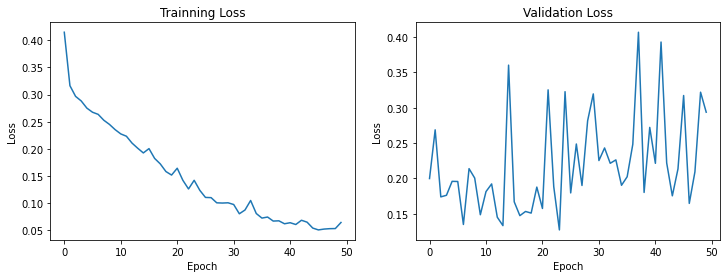

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(log_trn_loss)
axs[1].plot(log_val_loss)

axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")

axs[0].set_ylabel('Loss')
axs[1].set_ylabel('Loss')

axs[0].set_title('Trainning Loss')
axs[1].set_title('Validation Loss')

Text(0.5, 1.0, 'Validation IoU')

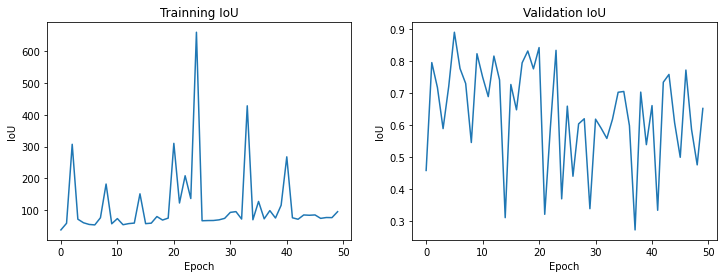

In [16]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(log_trn_iou)
axs[1].plot(log_val_iou)

axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")

axs[0].set_ylabel('IoU')
axs[1].set_ylabel('IoU')

axs[0].set_title('Trainning IoU')
axs[1].set_title('Validation IoU')

#### Examples

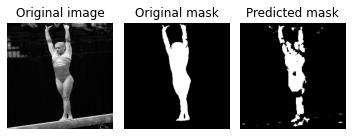

In [17]:
im, mask = next(iter(val_dl))
im , mask = im.to(device), mask.to(device)
_mask = model(im)


_, _mask = torch.max(_mask, dim=1)


subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])